In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram, find_peaks
from scipy.stats import ks_2samp, entropy
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error
from statsmodels.tsa.stattools import acf
from IPython.display import display

In [2]:
# 1. Load & Preprocess Real Data
csv_path = './data/weather/temp.csv'
df = pd.read_csv(csv_path, parse_dates=['date']).set_index('date')
y = df['T (degC)'].values
time = np.arange(len(y))

/var/folders/kw/zxdjxts97j33lc5_j5mmjgtm0000gn/T/ipykernel_7994/1301281969.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_path, parse_dates=['date']).set_index('date')


In [3]:
# Reserve 80% for parameter estimation, 20% for hold-out evaluation
t = len(y)
train_end = int(0.8 * t)
y_train, y_hold = y[:train_end], y[train_end:]
print(f"Training on first {train_end} points, holding out {t-train_end} points.")

Training on first 42156 points, holding out 10540 points.


In [4]:
# 2. Estimate SDG Parameters on Training Data
# 2.1 Detect dominant seasonal periods via periodogram
freqs, psd = periodogram(y_train)
peaks, _ = find_peaks(psd, distance=10)
# Avoid zero-frequency
peaks = peaks[freqs[peaks] > 0]
# Convert top-3 power peaks to integer periods
top = np.argsort(psd[peaks])[-3:]
periods = np.round(1 / freqs[peaks][top]).astype(int)
J = len(periods)
print(f"Detected seasonal periods: {periods}")


Detected seasonal periods: [ 1621   144 42156]


In [6]:
# 2.2 Fit multi-sinusoidal seasonality
X_season = np.column_stack([
    np.sin(2 * np.pi * time[:train_end] / P) for P in periods
] + [
    np.cos(2 * np.pi * time[:train_end] / P) for P in periods
])
lr_season = LinearRegression().fit(X_season, y_train)
coefs = lr_season.coef_
amplitudes = np.hypot(coefs[:J], coefs[J:])
phases = np.arctan2(coefs[J:], coefs[:J])

season_est = lr_season.predict(X_season)

In [7]:
# 2.3 Estimate linear trend on deseasonalized data
trend_lr = LinearRegression().fit(
    time[:train_end].reshape(-1, 1),
    y_train - season_est
)
beta = trend_lr.coef_[0]
intercept = trend_lr.intercept_
trend_est = trend_lr.predict(time[:train_end].reshape(-1, 1))

In [8]:
# 2.4 Compute residuals and fit AR(p)
resid = y_train - season_est - trend_est
max_lag = 10
ar_res = AutoReg(resid, lags=max_lag, old_names=False).fit()
phi = ar_res.params[1:]
noise_std = ar_res.resid.std()
print(f"AR coefficients (p={max_lag}): {phi}")
print(f"Trend slope beta: {beta:.4f}, intercept: {intercept:.4f}")

AR coefficients (p=10): [ 1.45083115 -0.56547752  0.20887223 -0.07700525  0.03042205 -0.01891516
  0.0086555  -0.01891196  0.00466677 -0.02705365]
Trend slope beta: 0.0000, intercept: -0.7948


In [10]:
# Package parameters
sdg_params = {
    'J': J,
    'periods': periods,
    'amplitudes': amplitudes,
    'phases': phases,
    'phi': phi,
    'beta': beta,
    'intercept': intercept,
    'noise_std': noise_std,
}
sdg_params

{'J': 3,
 'periods': array([ 1621,   144, 42156]),
 'amplitudes': array([1.11359104, 3.67317564, 8.06542755]),
 'phases': array([-2.51652028, -2.28902273, -2.74467837]),
 'phi': array([ 1.45083115, -0.56547752,  0.20887223, -0.07700525,  0.03042205,
        -0.01891516,  0.0086555 , -0.01891196,  0.00466677, -0.02705365]),
 'beta': np.float64(3.7709692608321825e-05),
 'intercept': np.float64(-0.7948260459519034),
 'noise_std': np.float64(0.2131115622682756)}

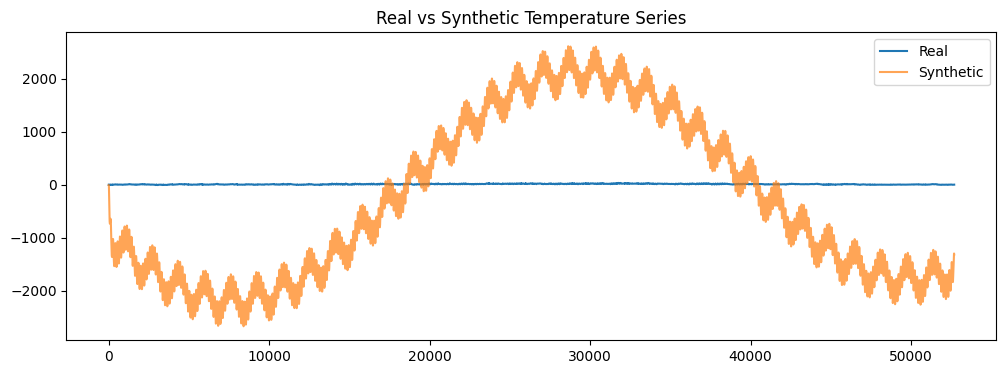

In [11]:
# 3. Synthetic Data Generator Function
def generate_synthetic(n, params, seed=None):
    rng = np.random.default_rng(seed)
    J, periods = params['J'], params['periods']
    A, theta = params['amplitudes'], params['phases']
    phi, beta, intercept = params['phi'], params['beta'], params['intercept']
    sigma = params['noise_std']
    p = len(phi)

    x = np.zeros(n)
    eps = rng.standard_normal(n) * sigma
    for t in range(n):
        ar_term = np.dot(phi, x[t-p:t][::-1]) if t >= p else 0
        s = sum(
            A[j] * np.sin(2 * np.pi * t / periods[j] + theta[j])
            for j in range(J)
        )
        tr = intercept + beta * t
        x[t] = ar_term + s + tr + eps[t]
    return x

# Generate one synthetic series for visualization
y_synth = generate_synthetic(t, sdg_params, seed=42)
plt.figure(figsize=(12,4))
plt.plot(time, y, label='Real')
plt.plot(time, y_synth, label='Synthetic', alpha=0.7)
plt.legend()
plt.title('Real vs Synthetic Temperature Series')
plt.show()

In [12]:
# 4. Define Evaluation Metrics
window = periods[0]
nlags = 30

def acf_l2(a, b):
    return np.sum((acf(a, nlags=nlags) - acf(b, nlags=nlags))**2)

def spectral_kl(x, y):
    p = periodogram(x)[1]
    q = periodogram(y)[1]
    return entropy(p/p.sum(), q/q.sum())

def ks_stat(x, y):
    return ks_2samp(x, y).statistic

def classifier_auc(x, y, win):
    X, Y = [], []
    for i in range(0, len(x)-win, win):
        X.append(x[i:i+win]); Y.append(0)
    for i in range(0, len(y)-win, win):
        X.append(y[i:i+win]); Y.append(1)
    X = np.array(X).reshape(-1, win)
    Y = np.array(Y)
    Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.3, random_state=42)
    prob = RandomForestClassifier(random_state=42).fit(Xtr, Ytr).predict_proba(Xte)[:,1]
    return roc_auc_score(Yte, prob)

def tstr(real_hold, synth_all):
    Xs, ys = [], []
    for i in range(train_end - window):
        Xs.append(synth_all[i:i+window]); ys.append(synth_all[i+window])
    mdl = Ridge().fit(np.array(Xs), np.array(ys))
    preds = [
        mdl.predict(real_hold[i-window:i].reshape(1,-1))[0]
        for i in range(window, len(real_hold))
    ]
    return mean_squared_error(real_hold[window:], preds)

def trts(real_train, synth_hold):
    Xr, yr = [], []
    for i in range(train_end - window):
        Xr.append(real_train[i:i+window]); yr.append(real_train[i+window])
    mdl = Ridge().fit(np.array(Xr), np.array(yr))
    preds = [
        mdl.predict(synth_hold[i-window:i].reshape(1,-1))[0]
        for i in range(window, len(synth_hold))
    ]
    return mean_squared_error(synth_hold[window:], preds)

In [13]:
# 5. Bootstrap Confidence Intervals for metrics
B = 200
def bootstrap_metric(fn):
    vals = []
    for seed in range(B):
        yb = generate_synthetic(t, sdg_params, seed)
        vals.append(fn(y_hold, yb[train_end:]))
    arr = np.array(vals)
    return arr.mean(), np.percentile(arr, [2.5, 97.5])

# Compute metrics
metrics = {
    'ACF L2': acf_l2,
    'Spectral KL': spectral_kl,
    'KS stat': ks_stat,
    'Classifier AUC': lambda r, s: classifier_auc(r, s, window)
}
results = []
for name, fn in metrics.items():
    m, ci = bootstrap_metric(fn)
    results.append((name, m, ci[0], ci[1]))
# Forecast tests
summary = pd.DataFrame(results, columns=['Metric','Mean','CI Lower','CI Upper'])
tstr_mse = tstr(y_hold, y_synth)
trts_mse = trts(y_train, y_synth[train_end:])

In [14]:
# 6. Display Results
print(summary)
print(f"TSTR MSE: {tstr_mse:.4f}, TRTS MSE: {trts_mse:.4f}")
display(summary)

           Metric      Mean  CI Lower  CI Upper
0          ACF L2  0.012599  0.012277  0.012916
1     Spectral KL  0.580061  0.574004  0.586134
2         KS stat  1.000000  1.000000  1.000000
3  Classifier AUC  1.000000  1.000000  1.000000
TSTR MSE: 0.0215, TRTS MSE: 1.0886


,Metric,Mean,CI Lower,CI Upper
0,ACF L2,0.012599,0.012277,0.012916
1,Spectral KL,0.580061,0.574004,0.586134
2,KS stat,1.000000,1.000000,1.000000
3,Classifier AUC,1.000000,1.000000,1.000000
